# Explore Results EMR Kerr

## Import utils

In [33]:
project_path = "../../../../../"

"../../../../../"

In [34]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load
import StatsBase: sample
# gr(); # specify backend for plotting

include(project_path * "src/utils/imports.jl")
import_project_utils(project_path);

  Activating project at `~/Escritorio/TFM/repo`


## Data paths

In [ ]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "kerr_from_schwarzschild/"
model_name = "kerr_from_schwarzschild/"

output_directory = project_path * "data/output/emr/" * test_name
output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
list_directories = (output_directory, output_dir, solutions_dir)
create_directories(list_directories)

## Load Model

In [36]:

# Define the experimental parameters
global datasize = 250
global mass_ratio = 0.0
global dt = 100.0


## Define neural network model
_, _, chain, _ = nn_model_emr_kerr_from_schwarzschild(64, relu);

# load saved models
@load solutions_dir*"model_chiphi.bson" chain

# restructure chains
NN_params, re = Flux.destructure(chain)
NN(u, NN_params) = re(NN_params)(u);

Initializating weights as zero.


## Dataset

In [37]:
datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters

χ₀ = Float64(pi/2); 
ϕ₀ = Float64(0.0);
p_space = [20.0]
M=Float64(1.0);
e = Float64(0.5)
tspan_train = (0, 12.0e3)
a_space = Float64.([1e-5, 0.4, 0.45, 0.65, 0.85])

test_info = [];
for a in a_space 
    for p in p_space
        train_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, a, tspan_train, datasize, dt);
        true_info = get_true_solution_EMR_kerr(train_info_i["u0"], train_info_i["model_params"], M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
        push!(test_info, merge(train_info_i, true_info))
    end
end

# put data in arrays
println("Processing datasets")
datasets = Dict("test" => test_info)
processed_data = process_datasets(datasets);

Processing datasets
Creating test dataset 


## Predictions

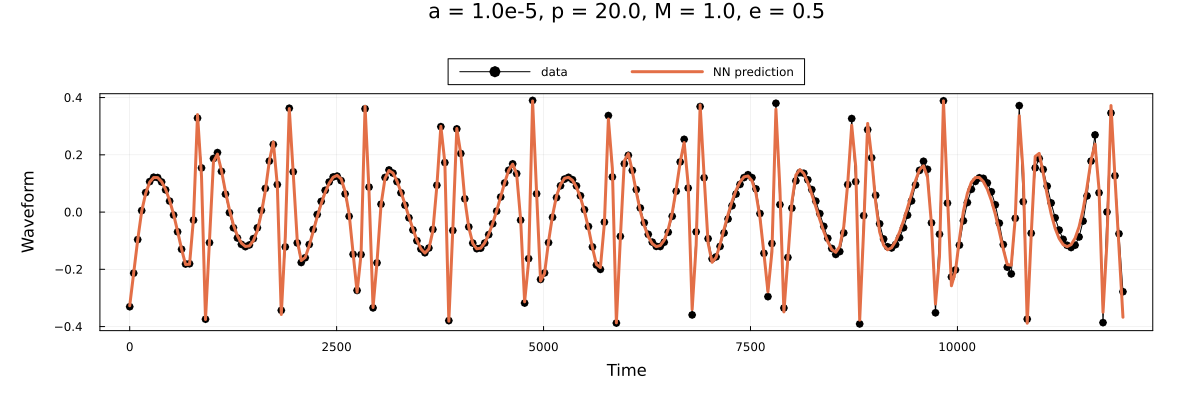

In [38]:
example = processed_data["test"][1]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
title = create_waveform_title(example["model_params"][1], example["model_params"][2], example["model_params"][3], example["model_params"][4])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform, size=(1200,400), title=title)

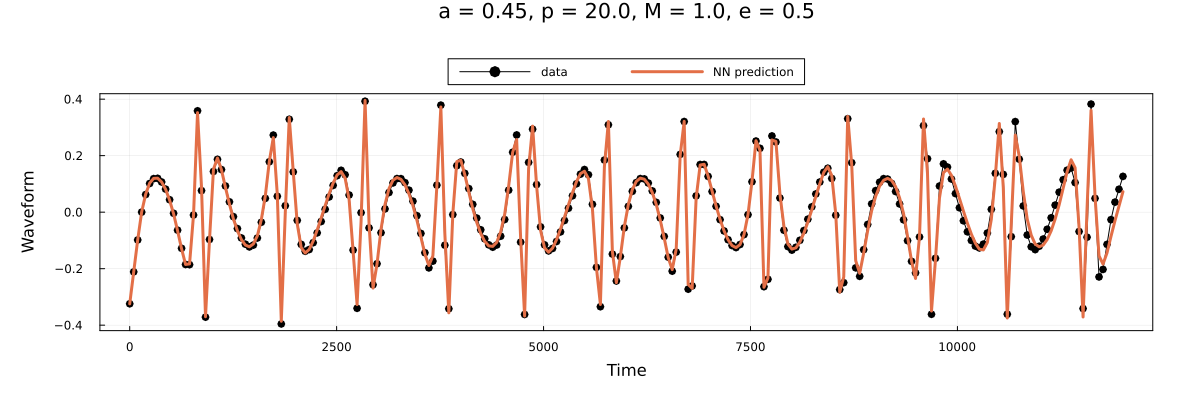

In [39]:
example = processed_data["test"][3]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
title = create_waveform_title(example["model_params"][1], example["model_params"][2], example["model_params"][3], example["model_params"][4])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform, size=(1200,400), title=title)

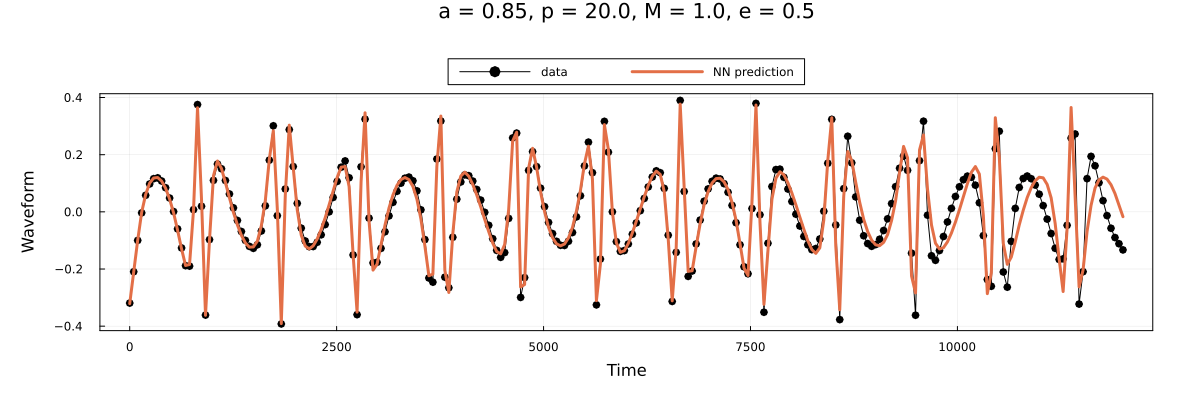

In [40]:
example = processed_data["test"][end]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
title = create_waveform_title(example["model_params"][1], example["model_params"][2], example["model_params"][3], example["model_params"][4])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform, size=(1200,400), title=title)

## Orbits Predictions

Get orbits predictions

In [11]:
predictions = Dict("train" => [], "test" => [])

for (set, set_data) in processed_data

    for wave in set_data

        println("Obtaining predictions for: ", set, " : ", wave["index"])

        solution_nn = Array(
            solve(wave["nn_problem"], RK4(), u0 = wave["u0"], 
            p = NN_params, saveat = wave["tsteps"], 
            dt = wave["dt_data"], adaptive=false
        ))

        predictions_wave_i = Dict()

        predictions_wave_i["tsteps"] = wave["tsteps"]
        predictions_wave_i["true_waveform"] = wave["true_waveform"]
        predictions_wave_i["pred_waveform"], _ = compute_waveform(wave["dt_data"], solution_nn, wave["q"], wave["M"], wave["model_params"])
        predictions_wave_i["pred_solution"] = solution_nn
        predictions_wave_i["true_solution"] = solution_nn
        predictions_wave_i["pred_orbit"] = soln2orbit(solution_nn, wave["M"], wave["model_params"])
        predictions_wave_i["true_orbit"] = soln2orbit(wave["true_solution"], wave["M"], wave["model_params"])
        predictions_wave_i["a"] = wave["model_params"][4]

        push!(predictions[set], predictions_wave_i)

    end

end


Obtaining predictions for: test : 1
Obtaining predictions for: test : 2
Obtaining predictions for: test : 3
Obtaining predictions for: test : 4
Obtaining predictions for: test : 5


plots

In [30]:
plot_list = [];

for (set, set_data) in predictions

    for wave in set_data

        title = uppercasefirst(set) * " predictions"

        # waveforms
        x1 = plot(
            wave["tsteps"], wave["true_waveform"], 
            markershape=:none, alpha = 0.5, 
            title= "a = " *string(wave["a"]),
            label="wform data (Re)",
            xlabel="Time",
            ylabel="Waveform",
            framestyle=:box,
            linewidth = line_width,
            left_margin = 20Plots.mm,
            bottom_margin = 5Plots.mm,
            size=(100,100),
    
            color=:black,
            seriestype=:scatter,
            ms=5,
        )
        plot!(
            x1, 
            wave["tsteps"], wave["pred_waveform"], 
            markershape=:none, linewidth = 2, alpha = 0.5, 
            label="wform NN (Re)",
                
            framestyle=:box,

            legendfontsize=legend_font_size-7,
            gridalpha=grid_alpha,
            gridstyle=grid_style,
        )

        # orbits
        orbits = wave["pred_orbit"]
        N = size(orbits, 2)
        x2 = plot(
            wave["true_orbit"][1,:][1:N],
            wave["true_orbit"][2,:][1:N],
            alpha = 0.5, aspect_ratio=:equal,
            label="data",
            xlabel="x",
            ylabel="y",
    
            bottom_margin = 5Plots.mm,
    
            legendfontsize=legend_font_size-7,
            titlefontsize=title_font_size,
            guidefontsize=title_font_size,
            linewidth = line_width,
            tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            left_margin = 20Plots.mm,
            framestyle=:box,
            color=:black,
            legend=:outertop,  
        )
        plot!(x2, orbits[1,1:end-1], orbits[2,1:end-1],
            alpha = 0.5, 
            aspect_ratio=:equal,
            label="NN",
            framestyle=:box,
            legendfontsize=legend_font_size-7,
            titlefontsize=title_font_size,
            guidefontsize=title_font_size,
            linewidth = line_width,
            tickfontsize = tick_font_size;
            gridalpha=grid_alpha,
            gridstyle=grid_style,
            # linestyle=:dash
        )

        plt = plot(x1, x2, layout=grid(1,2), size=(1500, 600))
        push!(plot_list, plt)
    
    end

end

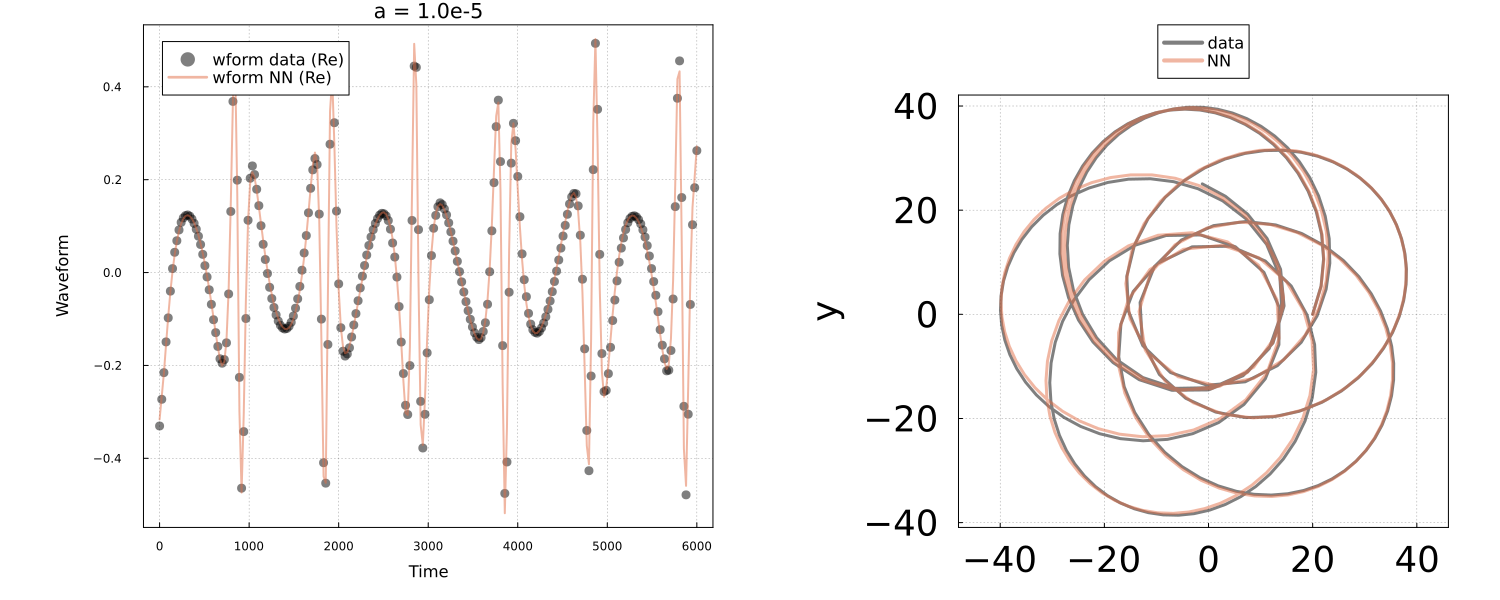

In [31]:
display(plot_list[1])

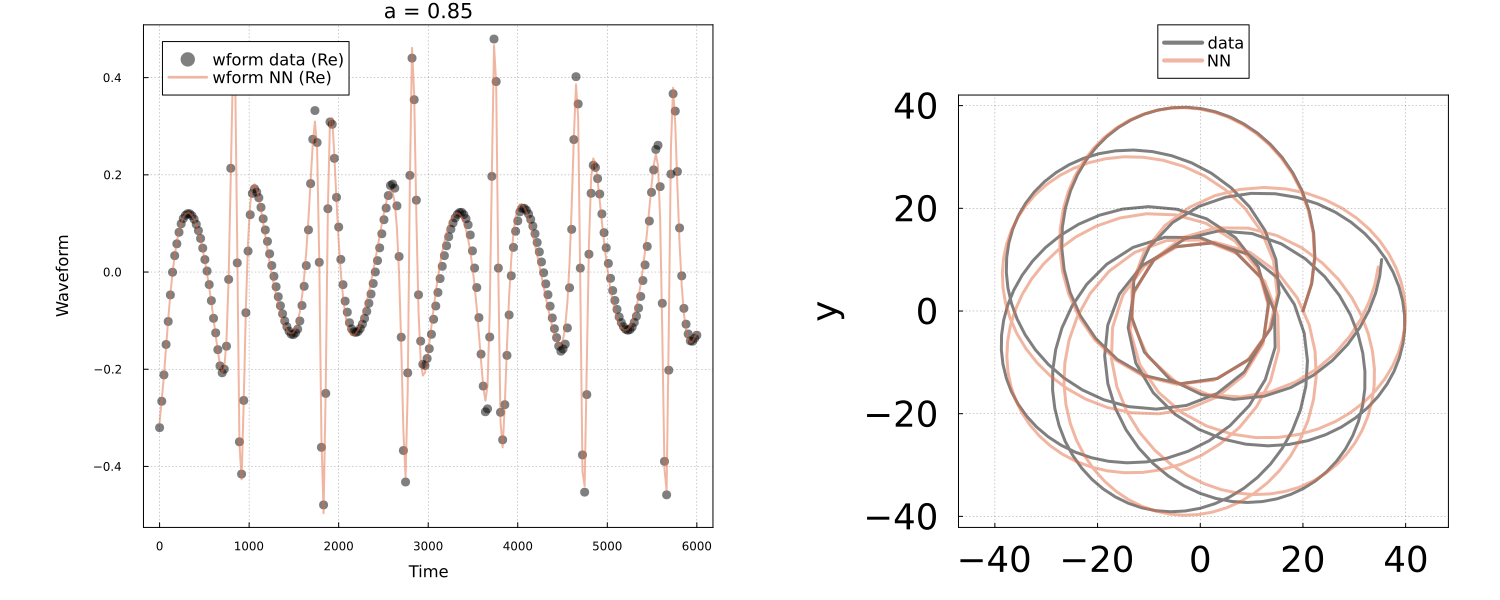

In [32]:
display(plot_list[end])

## Save Predictions

In [ ]:
# NOTE: this can be easily convert into a function and iterate over systems to save info

set = "train" # "test"
wave_index = 1 #

waveform_results_to_save = predictions[set][wave_index]

orbits = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_orbit_x" => waveform_results_to_save["pred_orbit"][1, :],
    "pred_orbit_y" => waveform_results_to_save["pred_orbit"][2, :],
    "true_orbit_x" => waveform_results_to_save["true_orbit"][1, :],
    "true_orbit_y" => waveform_results_to_save["true_orbit"][2, :]
)

equation_of_motion = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_solution_chi" => waveform_results_to_save["pred_solution"][1, :],
    "pred_solution_phi" => waveform_results_to_save["pred_solution"][2, :],
    "true_solution_chi" => waveform_results_to_save["true_solution"][1, :],
    "true_solution_phi" => waveform_results_to_save["true_solution"][2, :]
)

waveforms = DataFrame(
    "tsteps" => waveform_results_to_save["tsteps"],
    "pred_waveform" => waveform_results_to_save["pred_waveform"],
    "true_waveform" => waveform_results_to_save["true_waveform"]
)


CSV.write(predictions_dir*"waveforms.csv", waveforms)
CSV.write(predictions_dir*"equation_of_motion.csv", equation_of_motion)
CSV.write(predictions_dir*"orbits.csv", orbits);